# [E01]. Rock Scissor Paper

> **목차**
+ 루브릭 평가기준
+ 개요
+ 데이터 전처리 작업( 리사이징, 정규화)
+ 훈련
+ 시험
+ 회고

---

> **루브릭 평가기준**

+ 이미지 분류기 모델이 성공적으로 만들어졌는지?
+ 오버피팅을 극복하기 위한 적절한 시도가 있었는지?
+ 분류모델의 test accuracy가 기준 이상 높게 나왔는지? ( 정확도 60%이상)


>**개요**

---
시험에 들어가기 앞서 예상 및 시험 정보

---

훈련에 사용되는 데이터는 총 3900장으로 가위, 바위, 보 각각 1300장씩 할당했다.

추후 시험용 데이터는 새로운 데이터 300장으로 시험할 예정이다.

예상되는 문제점으로는
+ 새로운 데이터를 가지고 시험할 예정인데 그 데이터의 상태에 따라 실험의 정확도 차이가 클것으로 예상된다.
+ 검증용 데이터 없이 시험을 진행할 예정이라 분류기가 훈련에 너무 맞춰서 적응할 가능성이 있다.




>**데이터 전처리 작업 ( 리사이징 , 정규화 )**

***why 리사이징 ?***

***기존 이미지는 224x224의 사이즈인데 필요한 사진 크기는 28x28이기 때문***



In [12]:
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os




In [13]:
def resize_images(img_path): 
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path2)

print("바위 이미지 resize 완료!")

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path3)

print("보 이미지 resize 완료!")



1300  images to be resized.
1300  images resized.
가위 이미지 resize 완료!
1300  images to be resized.
1300  images resized.
바위 이미지 resize 완료!
1300  images to be resized.
1300  images resized.
보 이미지 resize 완료!


In [14]:
def load_data(img_path, number_of_data=3900):  # 가위바위보 이미지 개수 총합은 3900개이다. 각각 1300개
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 3900 입니다.
x_train shape: (3900, 28, 28, 3)
y_train shape: (3900,)


라벨:  0


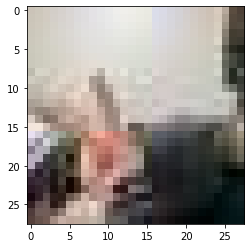

In [15]:
# 이미지 불러오기
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

> 딥러닝 네트워크 설계하기

In [58]:


n_channel_1=16   # 우선적 이미지의 특징 n개
n_channel_2=64   # 이후 n개씩의 특징  
n_dense=32       # 얼마나 복잡하게 할껀지 // 뉴런의 숫자
n_train_epoch=5 # 반복 횟수 

# MNIST 실험때 60000개를 가지고 실험한 반면 가위바위보는 3900개 표본으로 하기 때문에 복잡도와 반복횟수를 더 크게 했다.

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax')) # 가위바위보 세개를 구분하기 때문에 3을 넣었다.

model.summary() # 중간 확인

print("Before Reshape - x_train_norm shape: {}".format(x_train_norm.shape))
x_train_reshaped=x_train_norm.reshape( 3900, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.

print("After Reshape - x_train_reshaped shape: {}".format(x_train_reshaped.shape))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 11, 11, 64)        9280      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                51232     
_________________________________________________________________
dense_23 (Dense)             (None, 3)               

>**훈련**

In [59]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_reshaped, y_train, epochs=5)

Epoch 1/5
122/122 [==============================] - 1s 3ms/step - loss: 1.0320 - accuracy: 0.4679
Epoch 2/5
122/122 [==============================] - 0s 3ms/step - loss: 0.7521 - accuracy: 0.6985
Epoch 3/5
122/122 [==============================] - 0s 3ms/step - loss: 0.5403 - accuracy: 0.8051
Epoch 4/5
122/122 [==============================] - 0s 3ms/step - loss: 0.4029 - accuracy: 0.8621
Epoch 5/5
122/122 [==============================] - 0s 3ms/step - loss: 0.3220 - accuracy: 0.8913


In [60]:
# 리사이즈

def resize_images(img_path): 
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path4)

print("가위 이미지 resize 완료!")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path5 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path5)

print("바위 이미지 resize 완료!")

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path6 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path6)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


In [61]:
# 가위바위보 테스트 데이터 만들기

def load_data2(img_path, number_of_data=300):  #  테스트 이미지 300장
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data2(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

print("Before Reshape - x_test_norm shape: {}".format(x_test_norm.shape))
x_test_reshaped=x_test_norm.reshape( 300, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.

print("After Reshape - x_t_reshaped shape: {}".format(x_test_reshaped.shape))

학습데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
Before Reshape - x_test_norm shape: (300, 28, 28, 3)
After Reshape - x_t_reshaped shape: (300, 28, 28, 3)


> **시험 - 모델 확인 ( Evalueate ) **

In [62]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 0.7239 - accuracy: 0.7333
test_loss: 0.7239176630973816 
test_accuracy: 0.7333333492279053


> **회고**

# 시행착오
1차 시도(정확도 38%)
---
**실험조건**  
3900장의 사진   
n_channe1l_1=16   # 우선적 이미지의 특징 n개  
n_channel_2=32   # 이후 n개씩의 특징   
n_dense=128       # 얼마나 복잡하게 할껀지 // 뉴런의 숫자  
n_train_epoch=100 # 반복 횟수  

**결과**  
test_loss: 6.21818733215332  
test_accuracy: 0.3799999952316284  

**개선 방법 생각**  
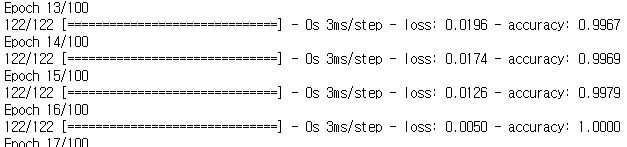  

100번이나 반복을 할 이유가 없음을 알 수 있었습니다.
그래서 다음에는 10회 정도로 조절을 해서 나온 결과값을 다시 분석해봐야 겠다는 결론이 나왔습니다.

2차 시도(정확도 46%)
---  
**실험조건**  
3900장의 사진 
n_channe1l_1=16   # 우선적 이미지의 특징 n개   
n_channel_2=32   # 이후 n개씩의 특징    
n_dense=128       # 얼마나 복잡하게 할껀지 // 뉴런의 숫자   
n_train_epoch=10 # 반복 횟수   

**결과**  
test_loss: 1.8674860000610352  
test_accuracy: 0.4633333384990692  

**개선 방법 생각**   
1차시도보다 약 9% 정도 정확도가 증가했으므로 반복 횟수를 좀 더 줄이는건 좋은 판단이었다는 생각이 들었으며, 
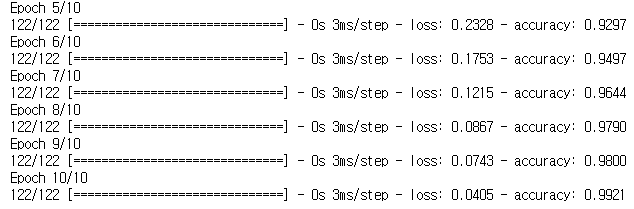
위의 자료를 보면 너무 오버 피팅이 되는것 같다는 생각이 들어 반복 횟수를 5회로 줄여서 분석 해봐야 겠다는 생각이 들었습니다.

3차 시도(정확도 48%)
---  
**실험조건**  
3900장의 사진 
n_channe1l_1=16   # 우선적 이미지의 특징 n개   
n_channel_2=32   # 이후 n개씩의 특징    
n_dense=128       # 얼마나 복잡하게 할껀지 // 뉴런의 숫자   
n_train_epoch=5 # 반복 횟수   

**결과**  
test_loss: 1.115067958831787 
test_accuracy: 0.4866666793823242 

**개선 방법 생각**   
반복으로 인한 오버피팅이 문제라는 생각을 했는데, 정확도는 2% 정도 밖에 증가하지 않았다.  
이번에는 뉴런의 숫자를 줄여서 분석을 새롭게 해봐야겠다는 생각이 들었습니다.

4차 시도(정확도 54%)
---  
**실험조건**  
3900장의 사진 
n_channe1l_1=16   # 우선적 이미지의 특징 n개   
n_channel_2=32   # 이후 n개씩의 특징    
n_dense=32       # 얼마나 복잡하게 할껀지 // 뉴런의 숫자   
n_train_epoch=5 # 반복 횟수   

**결과**  
test_loss: 0.948621928691864 
test_accuracy: 0.5433333516120911

**개선 방법 생각**   
드디어 54%로 유의미한 값이 나왔는데 이번 시도를 통해서 분류기의 정확도가 90프로 이상인게  
오히려 오버피팅이 되어 안좋은 결과값을 만들어 낸다는 생각이 들었습니다.  
다음 시도에서는 뉴런의 수를 좀 더 줄여서 오버 피팅을 줄이는 방향으로 시도 해보겠습니다.

5차 시도(정확도 46%)
---  
**실험조건**  
3900장의 사진 
n_channe1l_1=16   # 우선적 이미지의 특징 n개   
n_channel_2=32   # 이후 n개씩의 특징    
n_dense=16       # 얼마나 복잡하게 할껀지 // 뉴런의 숫자   
n_train_epoch=5 # 반복 횟수   

**결과**  
test_loss: 1.0836000442504883 
test_accuracy: 0.46000000834465027

**개선 방법 생각**   
뉴런의 수를 줄였더니 오히려 정확도가 떨어졌습니다. 때문에 뉴런 수는 이제 4차시도 그대로 두고 채널을 좀 더 크게 해서 다시 시도해보도록 하겠습니다.


6차 시도 (정확도 73%)
---  
**실험조건**  
3900장의 사진 
n_channe1l_1=16   # 우선적 이미지의 특징 n개   
n_channel_2=64   # 이후 n개씩의 특징    
n_dense=32       # 얼마나 복잡하게 할껀지 // 뉴런의 숫자   
n_train_epoch=5 # 반복 횟수   

**결과**  
test_loss: 0.7239176630973816 
test_accuracy: 0.7333333492279053


# 결론
---
## 초기 예측과 결과 차이점 분석
- 처음에 개요에서 우려했던 신규 데이터의 상태는 문제가 없었습니다.
- 반면에 검증용 데이터가 없어서 데이터가 제 생각보다 더 오버피팅됐습니다.
---
## 어려웠던 점
- 오버피팅과 충분한 훈련을 잘 조절해야 되는 점
- 처음 접해봤기 때문이지만, 컬러 이미지일 경우 MNIST와 다르게 층을 세개 더 추가해야되는 점
---
## 이번 과제를 통해 얻은 점
- 이미지를 받으면서 사람들이 정말 다양하게 찍어서 솔직히 내심 불안하다 싶은 사진들도 많았습니다. 그래서 최대한 학습을 늘렸는데 오히려 그게 잘못 될 수 있음을 배웠습니다.  
- 위 항목과 마찬가지로 뉴런의 수도 많으면 많을 수록 더 똑똑한 분류기가 될 것만 같아서 128이라는 큰 숫자를 넣고 했는데 결과적으로는 그 값이 오히려 정확도를 떨어뜨리게 됨을 알게 되었습니다.